In [1]:
import time
import timeit

import pandas as pd
import numpy as np
import numba as nb
from matplotlib import pyplot as plt

In [2]:
np.random.seed(23)

In [3]:
# Загрузим данные и переименуем столбцы.

interactions = pd.read_csv('interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [4]:
# Загрузим данные.

items = pd.read_csv('items.csv')
users = pd.read_csv('users.csv')

In [5]:
# Функция для генерации выборки

def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions['user_id'].unique(), users_count, replace=False)
    df = interactions[interactions['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    
    return df, users, recs

In [6]:
# Функции реализующие 3 варианта mrr.

def naive_mrr(target, users, recs):
    mrr = []
    r = 0
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                r = 1/(j+1)
                break
            else:
                r = 0
        mrr.append(r)
    return sum(mrr)/len(users)


def pandas_mrr(df, users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame({'user_id': np.repeat(users, k), 'item_id': recs.ravel()})
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df['target'] = 1
    df_recs = df_recs.merge(df, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df.drop(['target'], axis=1, inplace=True)
    df_recs['reciprocal_rank'] = 0
    df_recs.loc[~df_recs['target'].isna(), 'reciprocal_rank'] = 1/(df_recs.loc[~df_recs['target'].isna(), 'rank'])
    mrr = df_recs.groupby('user_id')['reciprocal_rank'].max().sum()/len(users)
    return mrr


# Функция для прогрева njit.
@nb.njit()
def summa(a, b):
    return a + b


@nb.njit()
def numba_mrr(target, users, recs):
    result_mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr = 1 / (j + 1)
                break
        result_mrr[i] = mrr
    return result_mrr.mean()

In [7]:
# Сначала проверим, что все три функции считают метрику одинаково.

top_k = 10
df, users, recs = generate_subsample(5000, top_k)
target = df.values

In [8]:
# Для прогрева njit.
a = 1
b = 2
summa(a, b)

3

In [9]:
# Выведем метрику, подсчитанную тремя способами. 

print(naive_mrr(target, users, recs))
print(pandas_mrr(df, users, recs))
print(numba_mrr(target, users, recs))

0.07879158730158735
0.0787915873015873
0.07879158730158735


In [10]:
# Замерим время выполнения функций.

%timeit naive_mrr(target, users, recs)

1.03 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit pandas_mrr(df, users, recs)

39.9 ms ± 653 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit numba_mrr(target, users, recs)

344 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# Посчитаем время с разным количеством пользователей и top к.

users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

naive_time = []
numba_time = []
pandas_time = []

for k in top_k:
    time_k_naive = []
    time_k_pandas = []
    time_k_numba = []
    
    for j in range(len(users_count)):
        df, users, recs = generate_subsample(users_count[j], k)
        target = df.values
        time = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs", number = 1)
        time_k_naive.append(time)
        print("Время выполнения метода naive  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", k)
        time = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number = 1)
        time_k_pandas.append(time)
        print("Время выполнения метода pandas  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", k)
        time = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number = 1)
        time_k_numba.append(time)
        print("Время выполнения метода numba  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", k)

    naive_time.append(time_k_naive)    
    numba_time.append(time_k_numba)    
    pandas_time.append(time_k_pandas)

Время выполнения метода naive   0.011087700000004475  Количество пользователей  100  Топ к равно  10
Время выполнения метода pandas   0.010396000000000072  Количество пользователей  100  Топ к равно  10
Время выполнения метода numba   0.0001883000000049151  Количество пользователей  100  Топ к равно  10
Время выполнения метода naive   0.12382470000000012  Количество пользователей  1000  Топ к равно  10
Время выполнения метода pandas   0.014915799999997148  Количество пользователей  1000  Топ к равно  10
Время выполнения метода numba   0.01365960000000399  Количество пользователей  1000  Топ к равно  10
Время выполнения метода naive   2.804449499999997  Количество пользователей  10000  Топ к равно  10
Время выполнения метода pandas   0.07729220000000225  Количество пользователей  10000  Топ к равно  10
Время выполнения метода numba   1.3953801999999982  Количество пользователей  10000  Топ к равно  10
Время выполнения метода naive   196.8311201  Количество пользователей  100000  Топ к р

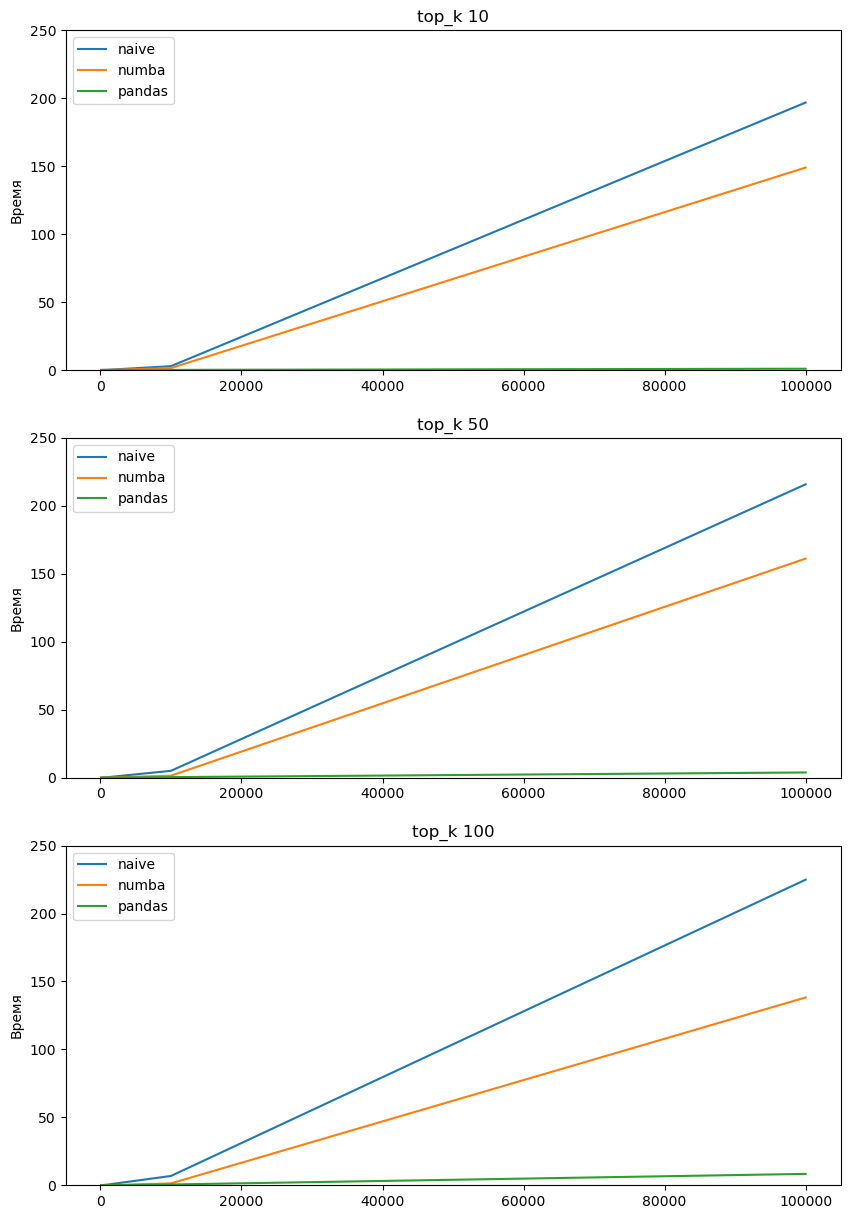

In [14]:
# Построим графики зависимости времени от количества пользователей при разных top k.

fx, ax = plt.subplots(3, figsize=(10, 15))
for i in range(3):
    ax[i].plot(users_count, naive_time[i], label='naive')
    ax[i].plot(users_count, numba_time[i], label='numba')
    ax[i].plot(users_count, pandas_time[i], label='pandas')
    ax[i].set_title(f'top_k {top_k[i]}')
    ax[i].set_ylabel('Время')
    ax[i].set_ylim(0, 250)
    ax[i].legend()
plt.show()

In [15]:
# Видим, что примерно до 10 000 пользователей разброс не сильный, а дальше графики расходятся значительней.

In [17]:
# Теперь посчитаем время с разным количеством и top к и фиксированным значением пользователей.

naive_time = []
numba_time = []
pandas_time = []

for users_c in users_count:
    time_users_naive = []
    time_users_pandas = []
    time_users_numba = []
    
    for j in range(len(top_k)):
        df, users, recs = generate_subsample(users_c, top_k[j])
        target = df.values
        time = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs", number = 1)
        time_users_naive.append(time)
        print("Время выполнения метода naive  ", time, " Количество пользователей ", users_c, " Топ к равно ", top_k[j])
        time = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number = 1)
        time_users_pandas.append(time)
        print("Время выполнения метода pandas  ", time, " Количество пользователей ", users_c, " Топ к равно ", top_k[j])
        time = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number = 1)
        time_users_numba.append(time)
        print("Время выполнения метода numba  ", time, " Количество пользователей ", users_c, " Топ к равно ", top_k[j])

    naive_time.append(time_users_naive)    
    numba_time.append(time_users_numba)    
    pandas_time.append(time_users_pandas)

Время выполнения метода naive   0.011156999999911932  Количество пользователей  100  Топ к равно  10
Время выполнения метода pandas   0.010372500000130458  Количество пользователей  100  Топ к равно  10
Время выполнения метода numba   0.00016609999988759228  Количество пользователей  100  Топ к равно  10
Время выполнения метода naive   0.026519100000086837  Количество пользователей  100  Топ к равно  50
Время выполнения метода pandas   0.010925900000074762  Количество пользователей  100  Топ к равно  50
Время выполнения метода numba   0.00021130000004632166  Количество пользователей  100  Топ к равно  50
Время выполнения метода naive   0.04524050000009083  Количество пользователей  100  Топ к равно  100
Время выполнения метода pandas   0.01252280000016981  Количество пользователей  100  Топ к равно  100
Время выполнения метода numba   0.00019079999992754892  Количество пользователей  100  Топ к равно  100
Время выполнения метода naive   0.11664169999994556  Количество пользователей  10

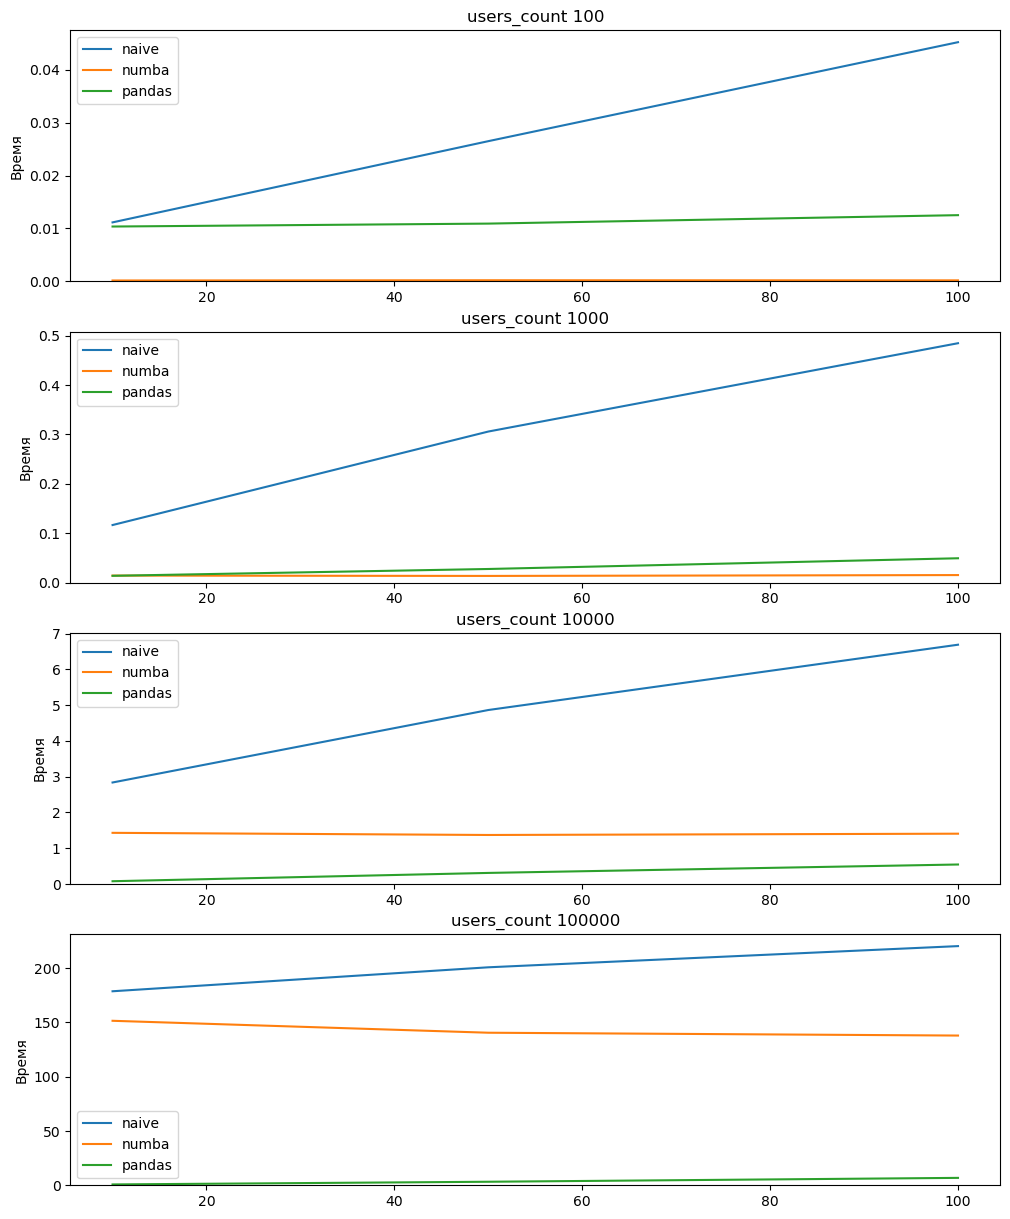

In [55]:
# Построим графики зависимости времени от количества top k при разных фиксированных количествах пользователей.

fx, ax = plt.subplots(4, figsize=(12, 15))
for i in range(4):
    ax[i].plot(top_k, naive_time[i], label='naive')
    ax[i].plot(top_k, numba_time[i], label='numba')
    ax[i].plot(top_k, pandas_time[i], label='pandas')
    ax[i].set_title(f'users_count {users_count[i]}')
    ax[i].set_ylabel('Время')
    ax[i].set_ylim(0, auto=True)
    ax[i].legend()
plt.show()